# DoomTakeCover-v0

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE


from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/enduro.config'])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [3]:
print(args.exp_name)

WorldModels


In [4]:
print(args.env_name)

Enduro-v0


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [6]:
filelist = os.listdir(DATA_DIR)

In [7]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [8]:
obs.shape

(4416, 64, 64)

In [9]:
# need reshape to convert 64x64x3 into 1x64x64x3
frame = random.choice(obs).reshape(1, 64, 64, 1)

In [10]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

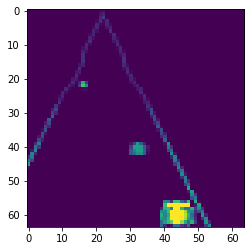

In [11]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [12]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[-0.0001  0.0142 -0.7872  0.1745 -0.3065 -0.2606 -0.8678 -0.968   0.2164  1.3965  2.0154 -0.7651
  1.7688 -0.4869  1.6015  1.3435  0.8522  0.1498 -0.7661  0.5137 -0.4551 -1.1581 -0.2395  0.6398
  0.3998 -1.2031 -0.7644 -1.1486  1.7132 -0.9209  0.1769 -2.0966  0.5968  0.2552 -0.2621 -0.5937
 -0.5762  0.4524 -0.9322  1.7351 -0.8865  1.3359 -0.5572  0.0987  0.325   1.9589 -0.5232 -0.1361
 -2.1387 -0.4598  0.4502 -0.4216 -0.0051  0.444   0.4727 -0.3434 -0.9715  0.6671 -1.2529 -1.3131
  0.5334  1.3563  0.4168  0.6871], shape=(64,), dtype=float32)


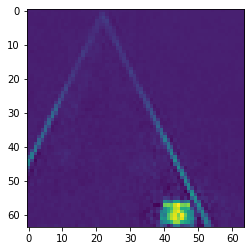

In [13]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

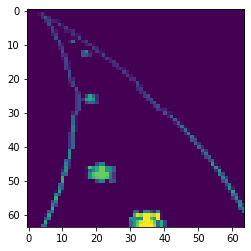

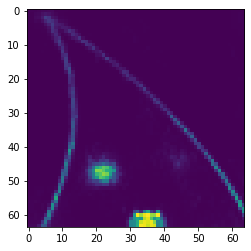

In [74]:
# need reshape to convert 64x64x3 into 1x64x64x3
frame = random.choice(obs).reshape(1, 64, 64, 1)
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()
batch_z = vae.encode(frame)
reconstruct = vae.decode(batch_z)
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

# Sample the VAE

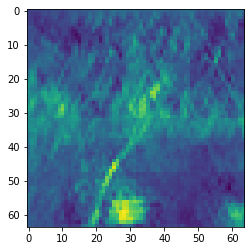

In [15]:
np.random.seed(65)
sample = np.random.rand(64).reshape(-1, 64)
reconstruct = vae.decode(sample)
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

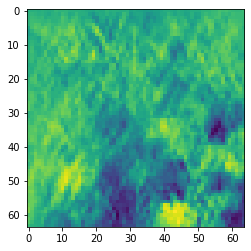

In [38]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()